In [1]:
!pip install --upgrade ultralytics --no-deps

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 15.2 MB/s eta 0:00:00


In [2]:
import json, shutil, yaml, warnings, gc, random, math, copy, os
from pathlib import Path
from PIL import Image
import numpy as np
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from tqdm.auto import tqdm
from ultralytics import YOLO
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(42); random.seed(42); np.random.seed(42)
torch.backends.cudnn.benchmark = True
print("Device:", device, "| torch", torch.__version__)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Device: cuda | torch 2.6.0+cu124


In [3]:
import os

# Base dataset path (update according to what the print above shows)
base_path = "/kaggle/input/aerial-vehicle-obb-dataset/RoadVehiclesYOLOOBBDataset"

yaml_content = f"""
# YOLO Dataset Configuration File

train: {base_path}/train/images
val: {base_path}/val/images
test: {base_path}/test/images

nc: 2
names: ['small-vehicle', 'large-vehicle']
"""

yaml_path = "/kaggle/working/data_vehicle.yaml"

with open(yaml_path, "w") as f:
    f.write(yaml_content.strip())

print("✅ data.yaml updated and saved successfully.")

✅ data.yaml updated and saved successfully.


In [4]:
BASE  = Path("/kaggle/input/aerial-vehicle-obb-dataset/RoadVehiclesYOLOOBBDataset")
WORK  = Path("/kaggle/working/")
DATA  = WORK/ "data_vehicle.yaml"
SSL_W = WORK/ "byol_backbone_with_hooks_y10.pth"
WORK.mkdir(parents=True, exist_ok=True)

In [5]:
def get_detect_module(model_module):
    """Return the Detect head (robust across YOLO versions)."""
    try:
        last = model_module.model[-1]
        if "Detect" in last.__class__.__name__:
            return last
    except Exception:
        pass
    cand = None
    for m in model_module.modules():
        if "Detect" in m.__class__.__name__:
            cand = m
    return cand if cand is not None else list(model_module.modules())[-1]

In [6]:
class TwoView(Dataset):
    SUPP = ('*.jpg','*.JPG','*.jpeg','*.JPEG','*.png','*.PNG','*.bmp','*.BMP','*.webp','*.WEBP')
    def __init__(self, roots, tfm):
        self.files=[]
        for r in roots:
            pr=Path(r)
            for p in self.SUPP:
                self.files.extend(pr.rglob(p))
        if not self.files: raise RuntimeError(f"No images found under {roots}")
        self.tfm=tfm
    def __len__(self): return len(self.files)
    def __getitem__(self,idx):
        img=Image.open(self.files[idx]).convert("RGB")
        return self.tfm(img), self.tfm(img)

augment = transforms.Compose([
    transforms.RandomResizedCrop(160, scale=(0.2, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.3,0.3,0.3,0.1),
    transforms.RandomGrayscale(0.2),
    transforms.GaussianBlur(kernel_size=7, sigma=(0.1, 2.0)),
    transforms.ToTensor(),
])

In [7]:
def byol_loss(p, z):
    p = F.normalize(p, dim=1)
    z = F.normalize(z, dim=1)
    return 2 - 2*(p*z).sum(dim=1).mean()

In [8]:
class DetectInputHook:
    def __init__(self, detect_module):
        self.handle = detect_module.register_forward_pre_hook(self.hook)
        self.feats = None
    def hook(self, module, inputs):
        # inputs is a tuple with a single item: a list/tuple of FPN maps [P3,P4,P5]
        self.feats = list(inputs[0])  # keep tensors with grad for online
        return None
    def close(self):
        self.handle.remove()

def global_pool_concat(feats):
    pooled = [F.adaptive_avg_pool2d(f, 1).flatten(1) for f in feats]
    return torch.cat(pooled, dim=1)

In [9]:
MODEL = "yolov10s.yaml"     # YOLOv12 nano config
SSL_EPOCHS, SSL_BATCH = 15, 8 # EPOCHS and BATCH SIZE
m0 = 0.996

if SSL_W.exists():
    print("✓ BYOL backbone cached – skipping pre-train")
else:
    print("\n🔄  BYOL pre-training (1 epoch, hook-based, YOLOv12) …")

    # full models (we'll read neck features via hook)
    online_full = YOLO(MODEL).model.to(device)
    target_full = YOLO(MODEL).model.to(device)
    target_full.load_state_dict(online_full.state_dict())
    for p in target_full.parameters(): p.requires_grad=False

    # register hooks on Detect heads to capture P3,P4,P5
    online_hook = DetectInputHook(get_detect_module(online_full))
    target_hook = DetectInputHook(get_detect_module(target_full))

    # infer feature dim
    with torch.no_grad():
        dmy = torch.zeros(1,3,160,160,device=device)
        _ = online_full(dmy)                # run forward to populate hook
        feat_dim = global_pool_concat(online_hook.feats).shape[1]
    print("Backbone feature dim:", feat_dim)

    def projector():
        return nn.Sequential(
            nn.Linear(feat_dim,512,bias=False),
            nn.BatchNorm1d(512), nn.ReLU(inplace=True),
            nn.Linear(512,256,bias=False)
        )
    def predictor():
        return nn.Sequential(
            nn.Linear(256,512,bias=False),
            nn.BatchNorm1d(512), nn.ReLU(inplace=True),
            nn.Linear(512,256,bias=False)
        )

    proj_o, proj_t = projector().to(device), projector().to(device)
    pred_o         = predictor().to(device)
    proj_t.load_state_dict(proj_o.state_dict())
    for p in proj_t.parameters(): p.requires_grad=False

    # optimize only online_full (backbone+neck) + projector/predictor
    opt = torch.optim.AdamW(
        list(online_full.parameters()) + list(proj_o.parameters()) + list(pred_o.parameters()),
        lr=1e-3, weight_decay=1e-4
    )
    scaler = torch.cuda.amp.GradScaler(enabled=(device=="cuda"))

    @torch.no_grad()
    def ema_update(src, dst, m):
        for ps, pd in zip(src.parameters(), dst.parameters()):
            pd.data.mul_(m).add_(ps.data, alpha=1-m)

    def momentum_scheduled(step, total_steps, base=m0):
        if total_steps <= 1: return 1.0
        tau = step / (total_steps - 1)
        return 1.0 - (1.0 - base) * (0.5 * (1.0 + math.cos(math.pi * tau)))

    ds = TwoView(["/kaggle/input/aerial-vehicle-obb-dataset/RoadVehiclesYOLOOBBDataset/train/images", "/kaggle/input/aerial-vehicle-obb-dataset/RoadVehiclesYOLOOBBDataset/val/images"], augment)
    dl = DataLoader(ds, batch_size=SSL_BATCH, shuffle=True,
                    num_workers=0, pin_memory=False, drop_last=True)

    total_steps = max(1, SSL_EPOCHS * len(dl))
    step = 0
    for ep in range(SSL_EPOCHS):
        online_full.train(); proj_o.train(); pred_o.train()
        running=0.0
        pbar = tqdm(dl, desc=f"BYOL {ep+1}/{SSL_EPOCHS}", leave=False)

        for v1,v2 in pbar:
            v1,v2 = v1.to(device, non_blocking=True), v2.to(device, non_blocking=True)
            m_cur = momentum_scheduled(step, total_steps)

            with torch.autocast(device_type='cuda', enabled=(device=="cuda")):
                # online encodes (features captured by hook)
                _ = online_full(v1)
                h1 = global_pool_concat(online_hook.feats)
                _ = online_full(v2)
                h2 = global_pool_concat(online_hook.feats)

                z1_o = proj_o(h1); z2_o = proj_o(h2)
                p1   = pred_o(z1_o); p2 = pred_o(z2_o)

                # target encodes (EMA, no grad)
                with torch.no_grad():
                    ema_update(online_full, target_full, m_cur)
                    ema_update(proj_o, proj_t, m_cur)
                    _ = target_full(v1)
                    h1_t = global_pool_concat(target_hook.feats)
                    _ = target_full(v2)
                    h2_t = global_pool_concat(target_hook.feats)
                    z1_t = proj_t(h1_t); z2_t = proj_t(h2_t)

                loss = byol_loss(p1, z2_t) + byol_loss(p2, z1_t)

            scaler.scale(loss).backward()
            scaler.step(opt); scaler.update(); opt.zero_grad(set_to_none=True)
            running += loss.item()
            step += 1
            pbar.set_postfix(loss=f"{loss.item():.4f}", m=f"{m_cur:.4f}")

        print(f"Epoch {ep+1}/{SSL_EPOCHS} BYOL loss={running/len(dl):.4f}")

    # save ONLY backbone+neck weights (exclude Detect head)
    torch.save({k:v for k,v in online_full.state_dict().items()
                if not k.startswith('model.%d' % (len(online_full.model)-1))}, SSL_W)

    online_hook.close(); target_hook.close()
    del online_full, target_full, proj_o, proj_t, pred_o, dl, ds
    gc.collect(); 
    if device=="cuda": torch.cuda.empty_cache()
    print("✓ Saved SSL backbone weights →", SSL_W)


🔄  BYOL pre-training (1 epoch, hook-based, YOLOv12) …
Backbone feature dim: 896


BYOL 1/15:   0%|          | 0/2961 [00:00<?, ?it/s]

Epoch 1/15 BYOL loss=0.5623


BYOL 2/15:   0%|          | 0/2961 [00:00<?, ?it/s]

Epoch 2/15 BYOL loss=0.5103


BYOL 3/15:   0%|          | 0/2961 [00:00<?, ?it/s]

Epoch 3/15 BYOL loss=0.5422


BYOL 4/15:   0%|          | 0/2961 [00:00<?, ?it/s]

Epoch 4/15 BYOL loss=0.5518


BYOL 5/15:   0%|          | 0/2961 [00:00<?, ?it/s]

Epoch 5/15 BYOL loss=0.4570


BYOL 6/15:   0%|          | 0/2961 [00:00<?, ?it/s]

Epoch 6/15 BYOL loss=0.4084


BYOL 7/15:   0%|          | 0/2961 [00:00<?, ?it/s]

Epoch 7/15 BYOL loss=0.4019


BYOL 8/15:   0%|          | 0/2961 [00:00<?, ?it/s]

Epoch 8/15 BYOL loss=0.4053


BYOL 9/15:   0%|          | 0/2961 [00:00<?, ?it/s]

Epoch 9/15 BYOL loss=0.3908


BYOL 10/15:   0%|          | 0/2961 [00:00<?, ?it/s]

Epoch 10/15 BYOL loss=0.3799


BYOL 11/15:   0%|          | 0/2961 [00:00<?, ?it/s]

Epoch 11/15 BYOL loss=0.3609


BYOL 12/15:   0%|          | 0/2961 [00:00<?, ?it/s]

Epoch 12/15 BYOL loss=0.3481


BYOL 13/15:   0%|          | 0/2961 [00:00<?, ?it/s]

Epoch 13/15 BYOL loss=0.3453


BYOL 14/15:   0%|          | 0/2961 [00:00<?, ?it/s]

Epoch 14/15 BYOL loss=0.3308


BYOL 15/15:   0%|          | 0/2961 [00:00<?, ?it/s]

Epoch 15/15 BYOL loss=0.3333
✓ Saved SSL backbone weights → /kaggle/working/byol_backbone_with_hooks_y10.pth


In [10]:
print("\n🚀 Fine-tuning YOLOv10-s (1 epoch) …")
det = YOLO(MODEL)  # nano to match SSL shapes
# load into all-but-Detect
sd = torch.load(SSL_W, map_location="cpu")
det.model.load_state_dict(sd, strict=False)

det.train(
    data = "/kaggle/working/data_vehicle.yaml",
    epochs=25,               
    imgsz=640,
    batch=8,
    project= "/kaggle/working/",
    name="byol_yolov10s",
    device=0 if device=="cuda" else None,
    verbose=True
)


🚀 Fine-tuning YOLOv10-s (1 epoch) …
Ultralytics 8.3.235 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/data_vehicle.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=25, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov10s.yaml, momentum=0.937, mosaic=1.0, multi_scale=False, name=byol_yolov10s, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, 

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7c4d70a754d0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04804


image 1/1 /kaggle/input/aerial-vehicle-obb-dataset/RoadVehiclesYOLOOBBDataset/test/images/drone_vsai_q_DJI_0792__1024__2976___1648.png: 640x640 (no detections), 8.6ms
Speed: 2.9ms preprocess, 8.6ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)


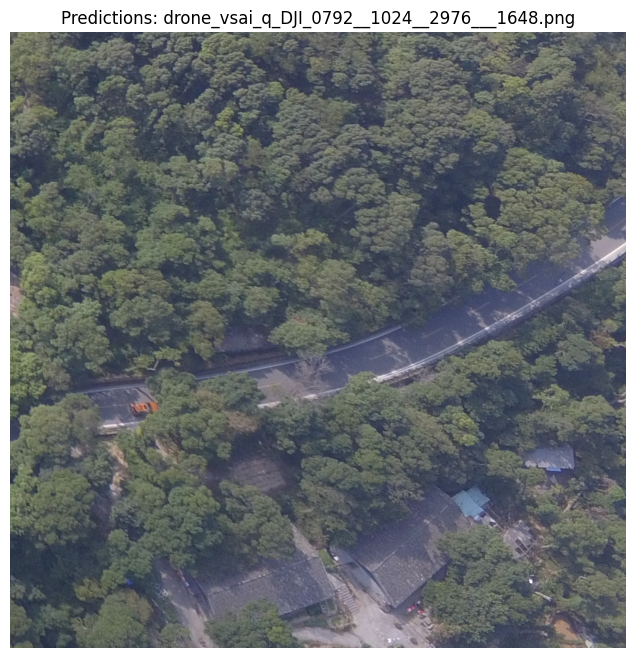


image 1/1 /kaggle/input/aerial-vehicle-obb-dataset/RoadVehiclesYOLOOBBDataset/test/images/dior_06593.jpg: 640x640 (no detections), 9.4ms
Speed: 2.6ms preprocess, 9.4ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)


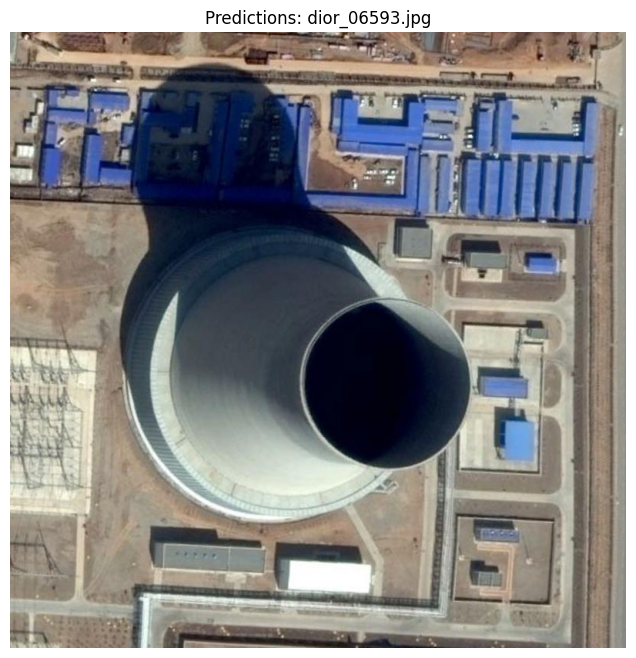


image 1/1 /kaggle/input/aerial-vehicle-obb-dataset/RoadVehiclesYOLOOBBDataset/test/images/drone_drone_05874_jpg.rf.458b6aeccfce4b4b4c927b5676a23aa7.jpg: 544x640 19 small-vehicles, 1413.5ms
Speed: 2.4ms preprocess, 1413.5ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)


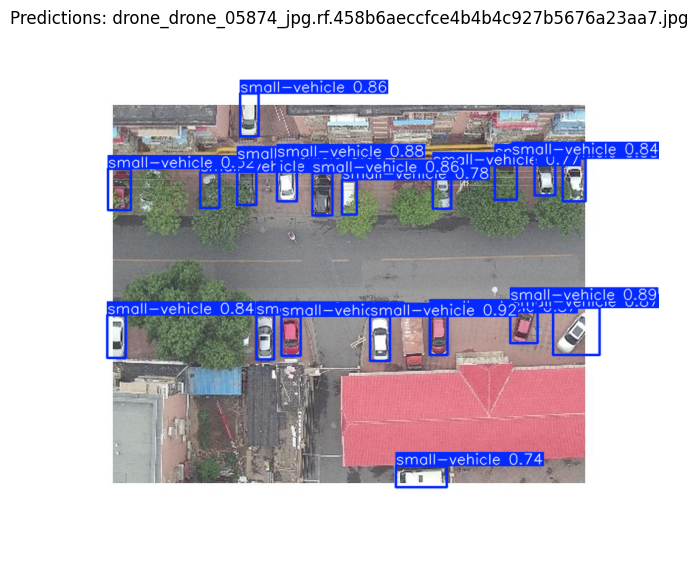


image 1/1 /kaggle/input/aerial-vehicle-obb-dataset/RoadVehiclesYOLOOBBDataset/test/images/drone_drone_07136_jpg.rf.9e19c4ba61a68ee67a641b84d93387dd.jpg: 544x640 11 small-vehicles, 9.6ms
Speed: 2.3ms preprocess, 9.6ms inference, 0.4ms postprocess per image at shape (1, 3, 544, 640)


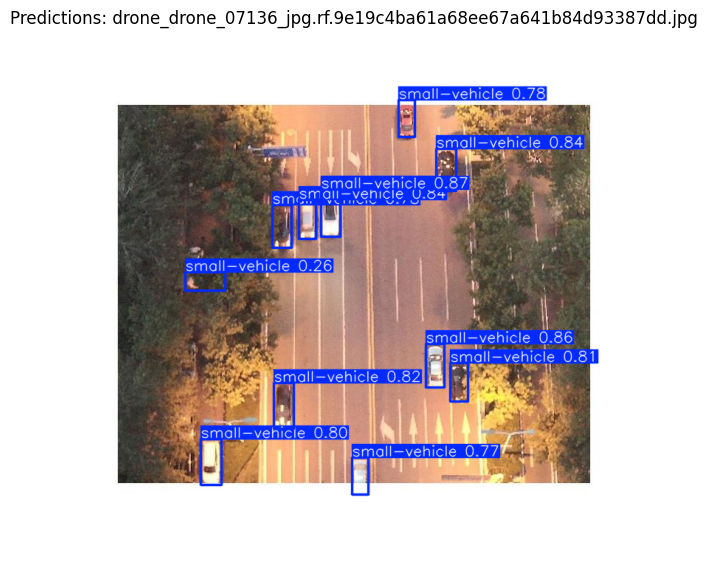


image 1/1 /kaggle/input/aerial-vehicle-obb-dataset/RoadVehiclesYOLOOBBDataset/test/images/drone_vsai_u_DJI_0073__1024__0___824.png: 640x640 108 small-vehicles, 10.4ms
Speed: 2.8ms preprocess, 10.4ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)


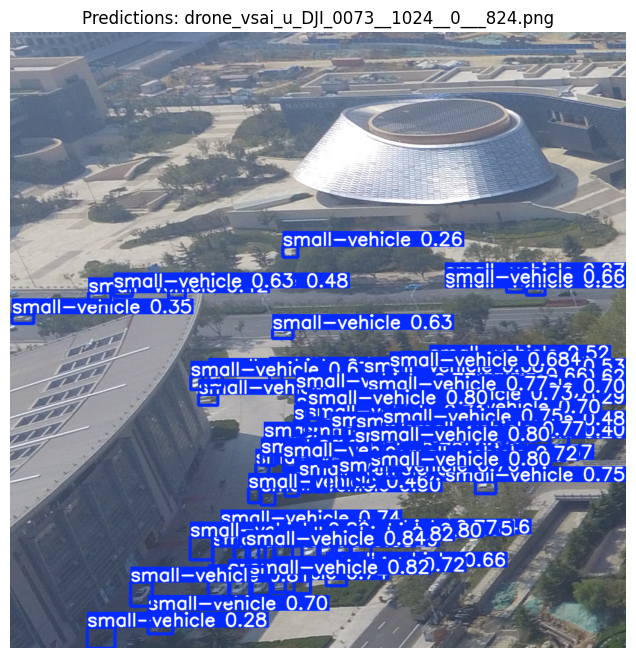

In [11]:
import os
import random
import matplotlib.pyplot as plt
from ultralytics import YOLO
import cv2

# Load your trained YOLOv12 model
model = YOLO("/kaggle/working/byol_yolov10s/weights/best.pt")

# ✅ Path to test images
test_images_dir = "/kaggle/input/aerial-vehicle-obb-dataset/RoadVehiclesYOLOOBBDataset/test/images"

# Randomly pick 5 images
image_paths = os.listdir(test_images_dir)
random_images = random.sample(image_paths, 5)

# Show predictions
for img_name in random_images:
    img_path = os.path.join(test_images_dir, img_name)
    results = model.predict(img_path, conf=0.25)

    # Visualize predictions
    res_plotted = results[0].plot()  # plotted NumPy image (BGR)
    plt.figure(figsize=(8, 8))
    plt.imshow(cv2.cvtColor(res_plotted, cv2.COLOR_BGR2RGB))
    plt.title(f"Predictions: {img_name}")
    plt.axis("off")
    plt.show()

In [12]:
from ultralytics import YOLO
import numpy as np

# Load best trained model
model = YOLO("/kaggle/working/byol_yolov10s/weights/best.pt")

# Evaluate the model on the validation set
metrics = model.val()

# Helper function to safely extract scalar values
def get_scalar(value):
    if isinstance(value, (np.ndarray, list)):
        return float(np.mean(value))  # take average if array
    return float(value)

# Extract metrics
map50 = get_scalar(metrics.box.map50)
map5095 = get_scalar(metrics.box.map)
precision = get_scalar(metrics.box.p)
recall = get_scalar(metrics.box.r)
f1 = get_scalar(metrics.box.f1)

# Print results
print("\n📊 Model Evaluation Results:")
print(f"Model Name       : {model.model.name if hasattr(model.model, 'name') else 'YOLOv10 Vehicle Model'}")
print(f"mAP@0.5          : {map50:.4f}")
print(f"mAP@0.5:0.95     : {map5095:.4f}")
print(f"Precision        : {precision:.4f}")
print(f"Recall           : {recall:.4f}")
print(f"F1-Score         : {f1:.4f}")

Ultralytics 8.3.235 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv10s summary (fused): 106 layers, 7,218,774 parameters, 0 gradients
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 304.8±472.1 MB/s, size: 692.3 KB)
val: Scanning /kaggle/input/aerial-vehicle-obb-dataset/RoadVehiclesYOLOOBBDataset/val/labels... 5420 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 5420/5420 370.5it/s 14.6s
WARNING ⚠️ val: Cache directory /kaggle/input/aerial-vehicle-obb-dataset/RoadVehiclesYOLOOBBDataset/val is not writable, cache not saved.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 339/339 4.4it/s 1:18
                   all       5420      81053      0.801      0.713      0.786      0.511
         small-vehicle       4592      71035      0.891      0.852      0.918       0.61
         large-vehicle       2394      10018      0.712      0.575      0.654      0.412
Speed: 0.8ms preprocess, 10.0ms inference, 0.0ms

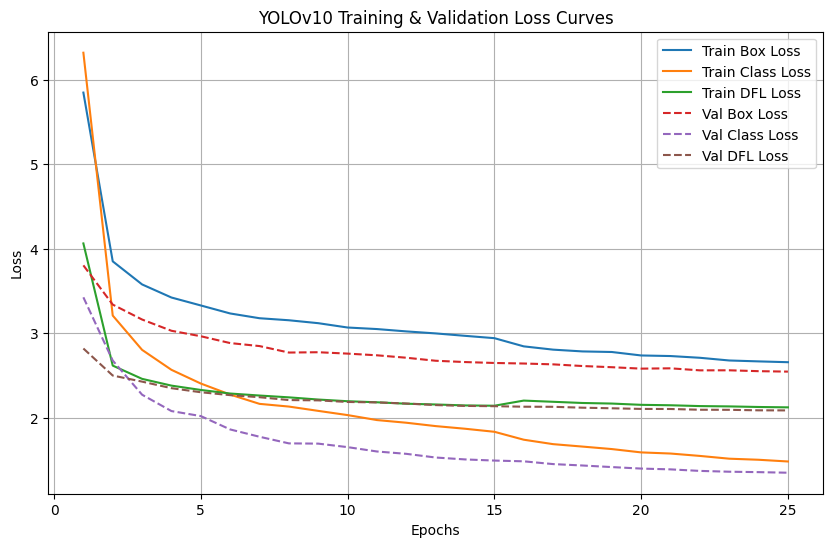

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# Path to results CSV file generated automatically
csv_path = "/kaggle/working/byol_yolov10s/results.csv"

# Read CSV data
df = pd.read_csv(csv_path)

# Plot losses
plt.figure(figsize=(10,6))
plt.plot(df["epoch"], df["train/box_loss"], label="Train Box Loss")
plt.plot(df["epoch"], df["train/cls_loss"], label="Train Class Loss")
plt.plot(df["epoch"], df["train/dfl_loss"], label="Train DFL Loss")
plt.plot(df["epoch"], df["val/box_loss"], '--', label="Val Box Loss")
plt.plot(df["epoch"], df["val/cls_loss"], '--', label="Val Class Loss")
plt.plot(df["epoch"], df["val/dfl_loss"], '--', label="Val DFL Loss")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("YOLOv10 Training & Validation Loss Curves")
plt.legend()
plt.grid(True)
plt.show()